In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
from collections import Counter, defaultdict

from time import time

%matplotlib inline

import scipy.sparse

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize']= 'large'

In [3]:
stop_list = {"byte", "short", "int", "long", "float", "double", "boolean", "char", 
             "GENERIC_PARAM"}

def keep(type): 
    if type in stop_list:
        return False
    
    if type.startswith("java"):
        return False
    
    return True

def extract_ids(data):
    pairs = [(d['type']['fullName'], d['name']) for d in data['ids']]
    return [(type, name) for (type, name) in pairs if keep(type)]

In [4]:
class_names = []
packages = []
ids = []

for line in file('C:/tmp/mlp/jlp-mahout.json'):
    data = json.loads(line)
    class_names.append(data[u'className'])
    packages.append(data[u'packageName'])
    ids.append(extract_ids(data))

In [28]:
len(set(packages))

155

In [5]:
len(ids)

1560

In [6]:
sum(len(id_list) for id_list in ids)

15869

In [7]:
Counter(packages).most_common(10)

[(u'org.apache.mahout.math.map', 194),
 (u'org.apache.mahout.math', 104),
 (u'org.apache.mahout.math.function', 92),
 (u'org.apache.mahout.classifier.sgd', 47),
 (u'org.apache.mahout.text', 35),
 (u'org.apache.mahout.cf.taste.impl.common', 35),
 (u'org.apache.mahout.cf.taste.impl.recommender', 34),
 (u'org.apache.mahout.math.list', 27),
 (u'org.apache.mahout.common', 27),
 (u'org.apache.mahout.math.set', 25)]

In [8]:
cnt = Counter()

for id_list in ids:
    cnt.update(id_list)
    
cnt.most_common(20)

[((u'org.apache.hadoop.conf.Configuration', u'conf'), 491),
 ((u'org.apache.mahout.math.Vector', u'v'), 224),
 ((u'org.apache.mahout.cf.taste.model.DataModel', u'dataModel'), 207),
 ((u'org.apache.hadoop.fs.FileSystem', u'fs'), 207),
 ((u'org.slf4j.Logger', u'log'), 171),
 ((u'org.apache.hadoop.fs.Path', u'output'), 152),
 ((u'org.apache.mahout.math.Vector', u'vector'), 145),
 ((u'org.apache.mahout.math.Vector', u'x'), 120),
 ((u'org.apache.hadoop.fs.Path', u'path'), 113),
 ((u'org.apache.mahout.common.distance.DistanceMeasure', u'measure'), 102),
 ((u'org.apache.hadoop.fs.Path', u'input'), 101),
 ((u'org.apache.mahout.math.Vector', u'y'), 87),
 ((u'org.apache.mahout.math.function.IntComparator', u'comp'), 74),
 ((u'org.apache.hadoop.mapreduce.Job', u'job'), 71),
 ((u'org.apache.mahout.math.Matrix', u'm'), 70),
 ((u'org.apache.mahout.math.Swapper', u'swapper'), 65),
 ((u'org.apache.hadoop.fs.Path', u'outputPath'), 61),
 ((u'org.apache.mahout.cf.taste.model.PreferenceArray', u'prefs'), 

In [9]:
cnt_type = Counter()

for id_list in ids:
    cnt_type.update([t for t, _ in id_list])
    
cnt_type.most_common(20)

[(u'org.apache.mahout.math.Vector', 1667),
 (u'org.apache.hadoop.fs.Path', 1213),
 (u'org.apache.mahout.math.Matrix', 669),
 (u'org.apache.hadoop.conf.Configuration', 653),
 (u'org.apache.commons.cli2.Option', 275),
 (u'org.apache.mahout.math.list.IntArrayList', 246),
 (u'org.apache.mahout.math.list.DoubleArrayList', 245),
 (u'org.apache.mahout.math.list.ShortArrayList', 240),
 (u'org.apache.mahout.math.list.LongArrayList', 240),
 (u'org.apache.mahout.math.list.FloatArrayList', 240),
 (u'org.apache.mahout.math.list.ByteArrayList', 240),
 (u'org.apache.mahout.math.list.CharArrayList', 240),
 (u'org.apache.mahout.cf.taste.model.DataModel', 233),
 (u'org.apache.hadoop.fs.FileSystem', 231),
 (u'org.apache.mahout.math.function.DoubleDoubleFunction', 182),
 (u'org.slf4j.Logger', 177),
 (u'org.apache.mahout.math.VectorWritable', 171),
 (u'org.apache.mahout.common.Pair', 141),
 (u'org.apache.mahout.cf.taste.model.PreferenceArray', 137),
 (u'org.apache.mahout.common.distance.DistanceMeasure', 1

In [10]:
cnt_name = Counter()

for id_list in ids:
    cnt_name.update([v for _, v in id_list])
    
cnt_name.most_common(20)

[(u'map', 1170),
 (u'conf', 493),
 (u'list', 367),
 (u'keyList', 336),
 (u'other', 307),
 (u'v', 289),
 (u'procedure', 284),
 (u'valueList', 281),
 (u'keys', 259),
 (u'context', 249),
 (u'map2', 210),
 (u'fs', 209),
 (u'dataModel', 208),
 (u'log', 171),
 (u'output', 163),
 (u'x', 163),
 (u'vector', 161),
 (u'key', 148),
 (u'input', 140),
 (u'values', 139)]

## Clustering

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, randomized_svd
from sklearn.cluster import KMeans, MiniBatchKMeans

In [12]:
def unwrap_pairs(pairs):
    res = []
    for type, var in pairs:
        res.append(type)
        res.append(var)
    return res

vectorizer = TfidfVectorizer(analyzer=unwrap_pairs, sublinear_tf=1, min_df=2)
X = vectorizer.fit_transform(ids)

In [13]:
X

<1560x1436 sparse matrix of type '<type 'numpy.float64'>'
	with 13083 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(copy=False)

In [15]:
n = 200
U, S, Vt = randomized_svd(X, n_components=n)
V = Vt.T

X_red = X.dot(V)
X_red = normalizer.fit_transform(X_red)

In [16]:
def cluster_purity(labels, k):
    indices, = np.where(labels == k)    
    size = len(indices)
    if size == 0:
        return 0.0, 0, ''

    c = Counter([packages[int(idx)] for idx in indices])
    cat, count = c.most_common(1)[0]
    purity = 1.0 * count / size
    return purity, size, cat

In [17]:
def calc_purity(labels):
    k_max = labels.max()
    N = len(labels)

    purities = []
    sizes = []
    for k in xrange(k_max):
        purity, size, cat = cluster_purity(labels, k)
        if size == 0:
            continue
        
        purities.append(purity)
        sizes.append(1.0 * size / N)

    return np.dot(purities, sizes)

In [18]:
def find_pure_clusters(labels, purity_threshold=0.8, min_size=5):
    k_max = labels.max()
    N = len(labels)

    clusters = []
    for k in xrange(k_max):
        purity, size, cat = cluster_purity(labels, k)
        if size <= min_size or purity <= purity_threshold:
            continue

        clusters.append((k, purity, size, cat))
    return clusters

In [166]:
ns = [100, 200, 300, 400]
ks = [100, 200, 300, 400, 500, 600, 700]

total_purity = []
total_len = []

for n in ns:
    U, S, Vt = randomized_svd(X, n_components=n)
    V = Vt.T

    X_red = X.dot(V)
    X_red = normalizer.fit_transform(X_red)
    X_red = normalizer.transform(X_red)

    for k in ks:
        purities = []
        sizes = []
        
        for i in xrange(10):
            km = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
            km.fit(X_red)

            labels = km.labels_

            purity = calc_purity(labels)
            total_purity.append((n, k, i, purity))
            no_clusters = len(find_pure_clusters(labels))
            total_len.append((n, k, i, no_clusters))

            purities.append(purity)
            sizes.append(no_clusters)

            print "n=%d, k=%d, try %d, result: purity=%0.4f, size=%d" % (n, k, i, purity, no_clusters)
            
        print "for n=%d, k=%d, avg_purity=%0.4f, avg_size=%0.1f" % (n, k, np.mean(purities), np.mean(sizes))
        print 

n=100, k=100, try 0, result: purity=0.4295, size=16
n=100, k=100, try 1, result: purity=0.4436, size=19
n=100, k=100, try 2, result: purity=0.4250, size=18
n=100, k=100, try 3, result: purity=0.4372, size=20
n=100, k=100, try 4, result: purity=0.4474, size=23
n=100, k=100, try 5, result: purity=0.4353, size=16
n=100, k=100, try 6, result: purity=0.4603, size=20
n=100, k=100, try 7, result: purity=0.4417, size=15
n=100, k=100, try 8, result: purity=0.4353, size=19
n=100, k=100, try 9, result: purity=0.4276, size=18
for n=100, k=100, avg_purity=0.4383, avg_size=18.4

n=100, k=200, try 0, result: purity=0.5353, size=29
n=100, k=200, try 1, result: purity=0.5288, size=29
n=100, k=200, try 2, result: purity=0.5282, size=24
n=100, k=200, try 3, result: purity=0.5314, size=30
n=100, k=200, try 4, result: purity=0.5103, size=28
n=100, k=200, try 5, result: purity=0.5090, size=23
n=100, k=200, try 6, result: purity=0.5256, size=29
n=100, k=200, try 7, result: purity=0.5179, size=34
n=100, k=200

In [167]:
df1 = pd.DataFrame(total_purity, columns=['n', 'k', 'i', 'purity'])
df2 = pd.DataFrame(total_len, columns=['n', 'k', 'i', 'sizes'])
df_res = pd.concat([df1, df2], axis=1, join='inner')[[0, 1, 3, 7]]

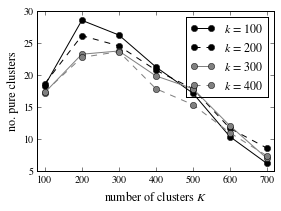

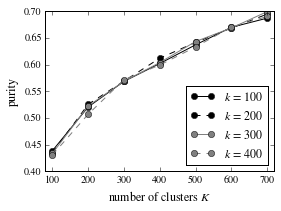

In [170]:
visual = {100: ('black', '-'), 200: ('black', '--'), 300: ('grey', '-'), 400: ('grey', '--')}

for n, g in df_res.groupby('n'):
    color, style = visual[n]
    g.groupby('k').mean().sizes.plot(marker='o', linestyle=style, figsize=(4, 3),
                                     color=color, label='$k$ = %d' % n)

plt.grid(0)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')
plt.legend()
plt.xlim(80, 720)

plt.tight_layout()
plt.savefig('figures/jlp-lens-sublin.pdf', format='pdf')


plt.show()



for n, g in df_res.groupby('n'):
    color, style = visual[n]
    g.groupby('k').mean().purity.plot(marker='o', linestyle=style, figsize=(4, 3),
                                     color=color, label='$k$ = %d' % n)

plt.grid(0)
plt.xlabel('number of clusters $K$')
plt.ylabel('purity')
plt.xlim(80, 720)

plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/jlp-pur-sublin.pdf', format='pdf')

plt.show()

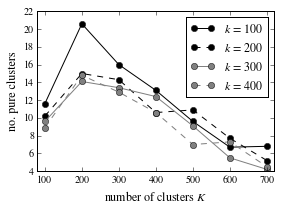

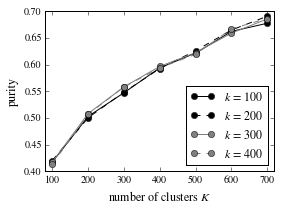

In [19]:
n = 100
k = 200

U, S, Vt = randomized_svd(X, n_components=n)
V = Vt.T

X_red = X.dot(V)
X_red = normalizer.fit_transform(X_red)
X_red = normalizer.transform(X_red)

best = (0, None)

for i in xrange(40):
    km = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
    km.fit(X_red)

    labels = km.labels_
    no_clusters = len(find_pure_clusters(labels))
    if best[0] < no_clusters:
        best = (no_clusters, labels)
        
    print "n=%d, k=%d, try %d, result: size=%d" % (n, k, i, no_clusters)

n=100, k=200, try 0, result: size=29
n=100, k=200, try 1, result: size=25
n=100, k=200, try 2, result: size=28
n=100, k=200, try 3, result: size=23
n=100, k=200, try 4, result: size=29
n=100, k=200, try 5, result: size=26
n=100, k=200, try 6, result: size=29
n=100, k=200, try 7, result: size=29
n=100, k=200, try 8, result: size=23
n=100, k=200, try 9, result: size=22
n=100, k=200, try 10, result: size=25
n=100, k=200, try 11, result: size=27
n=100, k=200, try 12, result: size=25
n=100, k=200, try 13, result: size=30
n=100, k=200, try 14, result: size=20
n=100, k=200, try 15, result: size=26
n=100, k=200, try 16, result: size=27
n=100, k=200, try 17, result: size=31
n=100, k=200, try 18, result: size=33
n=100, k=200, try 19, result: size=26
n=100, k=200, try 20, result: size=24
n=100, k=200, try 21, result: size=24
n=100, k=200, try 22, result: size=25
n=100, k=200, try 23, result: size=32
n=100, k=200, try 24, result: size=24
n=100, k=200, try 25, result: size=29
n=100, k=200, try 26, 

In [20]:
best

(34, array([146, 152,  11, ...,  98,  71, 186]))

In [21]:
len(Counter(packages))

155

In [22]:
clusters = find_pure_clusters(best[1])
clusters

[(0, 1.0, 8, u'org.apache.mahout.cf.taste.hadoop.als'),
 (13, 0.8888888888888888, 9, u'org.apache.mahout.math.map'),
 (16, 0.9166666666666666, 12, u'org.apache.mahout.math.map'),
 (22, 0.875, 8, u'org.apache.mahout.classifier.sgd'),
 (23, 0.8888888888888888, 9, u'org.apache.mahout.math.map'),
 (24, 0.8333333333333334, 6, u'org.apache.mahout.classifier.naivebayes'),
 (29, 0.9090909090909091, 11, u'org.apache.mahout.text'),
 (31, 0.8333333333333334, 6, u'org.apache.mahout.clustering.iterator'),
 (33, 0.9090909090909091, 11, u'org.apache.mahout.math.map'),
 (34, 0.9, 10, u'org.apache.mahout.math.map'),
 (40, 0.875, 8, u'org.apache.mahout.math.map'),
 (42, 0.875, 16, u'org.apache.mahout.h2obindings.ops'),
 (46, 1.0, 6, u'org.apache.mahout.math.map'),
 (48, 0.8333333333333334, 6, u'org.apache.mahout.common.distance'),
 (53, 0.875, 8, u'org.apache.mahout.math.map'),
 (69, 1.0, 6, u'org.apache.mahout.math.list'),
 (74, 1.0, 10, u'org.apache.mahout.vectorizer.collocations.llr'),
 (79, 0.818181

In [23]:
ids_123, _, _, _ = zip(*clusters)

In [24]:
def print_cluster(labels, k):
    indices, = np.where(labels == k)
    id_dict = defaultdict(list)
    
    print 'Classes:'
    for idx in indices:
        idx = int(idx)
        print '-', packages[idx] + '.' + class_names[idx]
        
        for cls, id in ids[idx]:
            id_dict[id].append(cls)
    
    print
    print 'Top 10 terms'
    centroid = X_red[indices].mean(axis=0)
    orig_space_centroid = V.dot(centroid)
    top_idx = orig_space_centroid.argsort()[::-1]
    terms = vectorizer.get_feature_names()

    for ind in top_idx[:10]:
        print '%s ' % terms[ind], 
    print

    id_cnt = {}
    for id, id_list in id_dict.items():
        id_cnt[id] = Counter(id_list)
        
    print 
    print 'Identifiers'
    id_cnt = sorted(id_cnt.items())

    for id, id_list in id_cnt:
        ids_print_list = ', '.join('%d x %s' % (cnt, name) for name, cnt in id_list.most_common())
        print '- %s: %s' % (id, ids_print_list)
    

In [25]:
for id in ids_123:
    centroid = X_red[best[1] == id].mean(axis=0)
    orig_space_centroid = V.dot(centroid)
    top_idx = orig_space_centroid.argsort()[::-1]
    terms = vectorizer.get_feature_names()

    print id,
    for ind in top_idx[:10]:
        print '%s ' % terms[ind], 
        
    print
    print

0 org.apache.mahout.cf.taste.hadoop.als.Context  ctx  org.apache.hadoop.conf.Configuration  org.apache.mahout.math.VectorWritable  org.apache.hadoop.fs.Path  conf  org.apache.hadoop.mapreduce.Job  org.apache.hadoop.io.Text  org.apache.hadoop.io.IntWritable  writer 

13 org.apache.mahout.math.list.FloatArrayList  list  keyList  procedure  theKeys  valueList  swapper  org.apache.mahout.math.Swapper  condition  org.apache.mahout.math.function.IntComparator 

16 map  org.apache.mahout.math.list.LongArrayList  keys  map2  values  o  k2  org.apache.mahout.math.list.IntArrayList  valueList  keyList 

22 org.apache.mahout.classifier.sgd.OnlineLogisticRegression  lr  org.apache.mahout.math.Vector  org.apache.mahout.classifier.sgd.LogisticModelParameters  result  v  org.apache.mahout.classifier.sgd.ModelDissector.Weight  other  w  org.apache.mahout.classifier.AbstractVectorClassifier 

23 org.apache.mahout.math.list.LongArrayList  list  procedure  copy  valueList  keyList  condition  org.apache.

### Some observations

Java source code is not really 100% same as math formulas corpus: 

- have subclasses - so here it's harder to tell when two things are same 


Same for both:

- "namespace defining" classes may be in the package that they don't define: these packages use the "namespace" packages and by usage of them in other packages we discribe